In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle

In [4]:
%%time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset
data_dir = "cropped_faces"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

CPU times: total: 0 ns
Wall time: 108 ms


### ResNet18

Implementation of ResNet18 architecture.

In [5]:
%%time
import torch
import torch.nn as nn
from torchvision.models import resnet18

# Load ResNet18
resnet_model = resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(dataset.classes))  # Adjust output layer

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = resnet_model.to(device)

CPU times: total: 93.8 ms
Wall time: 152 ms


In [88]:
%%time

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    accuracy = correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

CPU times: total: 0 ns
Wall time: 0 ns


In [89]:
%%time

def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

CPU times: total: 0 ns
Wall time: 0 ns


In [95]:
%%time
import torch.optim as optim

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
# Hyperparameters
num_epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

# ResNet Training
for epoch in range(num_epochs):
    # Call your training and evaluation functions
    train_loss, train_acc = train_model(resnet_model, train_loader, criterion, optimizer_resnet, device)
    val_loss, val_acc = evaluate_model(resnet_model, val_loader, criterion, device)
    
    # Append values (not extend, since these are float values)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    # Print epoch metrics
    print(f"Epoch {epoch+1}/{num_epochs}, ResNet - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/5, ResNet - Train Loss: 0.8079, Train Acc: 0.6125, Val Loss: 1.9877, Val Acc: 0.3810
Epoch 2/5, ResNet - Train Loss: 0.8299, Train Acc: 0.6375, Val Loss: 1.7380, Val Acc: 0.5714
Epoch 3/5, ResNet - Train Loss: 0.6263, Train Acc: 0.7125, Val Loss: 3.5849, Val Acc: 0.2857
Epoch 4/5, ResNet - Train Loss: 0.6290, Train Acc: 0.7125, Val Loss: 1.5383, Val Acc: 0.5714
Epoch 5/5, ResNet - Train Loss: 0.5481, Train Acc: 0.8375, Val Loss: 1.8631, Val Acc: 0.5714
CPU times: total: 35.5 s
Wall time: 13.4 s


In [97]:
torch.save(resnet_model.state_dict(), "resnet_model.pth")

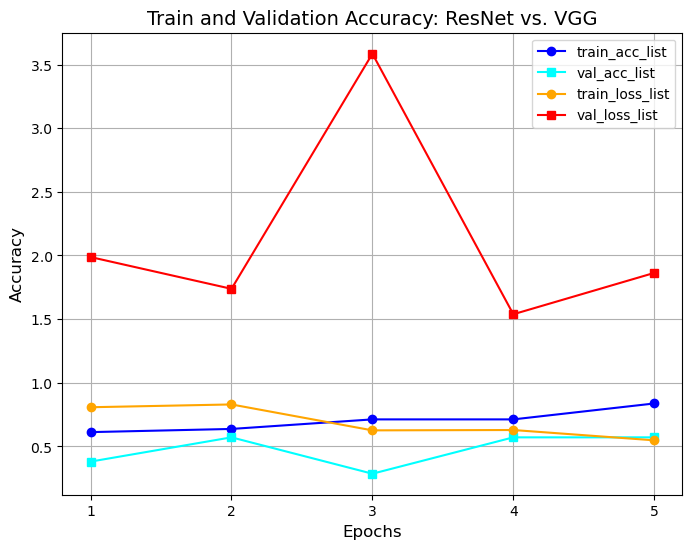

In [100]:
import matplotlib.pyplot as plt

num_epochs = 5
epochs = list(range(1, num_epochs + 1))


# Plotting
plt.figure(figsize=(8,6))

# ResNet Accuracy
plt.plot(epochs, train_acc_list, marker='o', label='train_acc_list', color='blue')
plt.plot(epochs, val_acc_list, marker='s', label='val_acc_list', color='cyan')

# VGG Accuracy
plt.plot(epochs, train_loss_list, marker='o', label='train_loss_list', color='orange')
plt.plot(epochs, val_loss_list, marker='s', label='val_loss_list', color='red')

# Adding labels, title, and legend
plt.title('Train and Validation Accuracy: ResNet vs. VGG', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


### Testing

In [6]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes: Dark, Light, Medium
model.load_state_dict(torch.load("resnet_model.pth"))
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the sample image
sample_image_path = "download.jpg"  # Replace with your sample image path
image = Image.open(sample_image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)

# Predict the type
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    class_names = ['Dark', 'Light', 'Medium']  # Must match folder names
    predicted_class = class_names[predicted.item()]

print(f"The predicted type of the image is: {predicted_class}")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13768\1343380716.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_model.pth"))


The predicted type of the image is: Light


1